Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

# This experiment use training data at (0,1) and (800,801) interval. 

hipothesis: variance should increase between 1 and 800 and between 800 and 1200. It should be maximum at 400 and 1200, max distance between known data.

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
n_samples = 10000
noise_percentaje=0.00 #no noise in this experiment
n_noise_samples=int(n_samples*noise_percentaje) #5% of samples
np.random.seed(4567)

In [3]:
#generate noise
if n_noise_samples is not 0:
    k_noise = 0
    theta_noise = 5
    #offset to locate noise 
    offset=1000
    noise_period=0.3
    extended_x=np.arange(offset, offset+noise_period, noise_period/n_noise_samples)
    #padding_zeros=np.zeros(int((n_samples-n_noise_samples)/2),dtype=float)
    partial_non_gaussian_noise = np.random.uniform(k_noise, theta_noise, n_noise_samples)
    plt.figure(figsize=(14,6))
    plt.plot(extended_x,partial_non_gaussian_noise, '.')

In [4]:
x = np.random.random(n_samples) 
#force add samples at (800,801) interval, putting them in x[800] to x[900]
for position in range(800,900,1):
    x[position]=800+(0.01*(position-800))
                     
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps
print(y.shape)

(10000,)


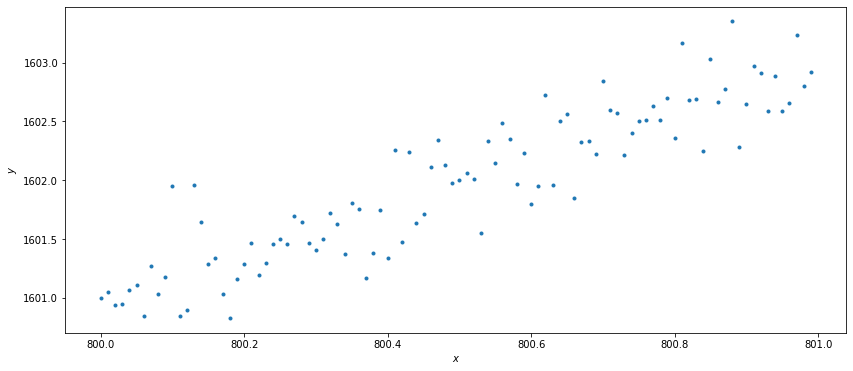

In [5]:
# Plot the data at 800
plt.figure(figsize=(14,6))
plt.plot(x[800:900], y[800:900], '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

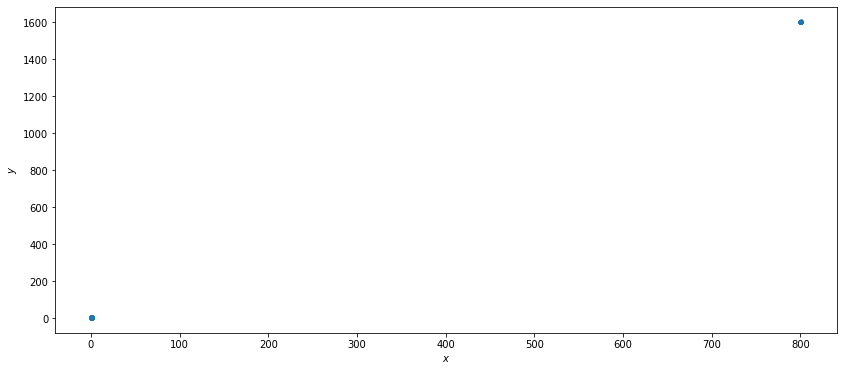

In [6]:
#NO NOISE AT THIS EXPERIMENT
#add noise
#y = y + far_away_non_gaussian_noise
if n_noise_samples is not 0:
  x=np.concatenate((x,extended_x))
  y=np.concatenate((y, partial_non_gaussian_noise))
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [7]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(n_samples+n_noise_samples)
y = np.stack([y, sigma], axis=1)

In [8]:
# Reshape x for PyTorch
x = x.reshape(n_samples+n_noise_samples, 1)

In [9]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [10]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [11]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [12]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [13]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [14]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [15]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 3.12e+04
epoch:  500, loss: 0.0887
epoch: 1000, loss: 0.0654
epoch: 1500, loss: 0.0625
epoch: 2000, loss: 0.0616
epoch: 2500, loss: 0.0612
epoch: 3000, loss: 0.061
epoch: 3500, loss: 0.0608
epoch: 4000, loss: 0.0606
epoch: 4500, loss: 0.0604
epoch: 5000, loss: 0.0603
epoch: 5500, loss: 0.0601
epoch: 6000, loss: 0.06
epoch: 6500, loss: 0.0598
epoch: 7000, loss: 0.0596
epoch: 7500, loss: 0.0594
epoch: 8000, loss: 0.0591
epoch: 8500, loss: 0.0588
epoch: 9000, loss: 0.0585
epoch: 9500, loss: 0.0582


### Get predictions for validation set 

In [16]:
# Get predicted y and sigma for validation set
x_val=np.arange(0.0,1200.0,10)
x_val=x_val.reshape(int(1200/10), 1)
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

### Plot results

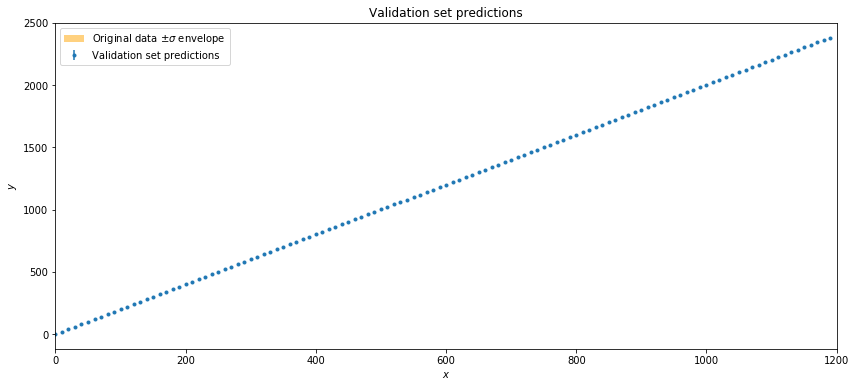

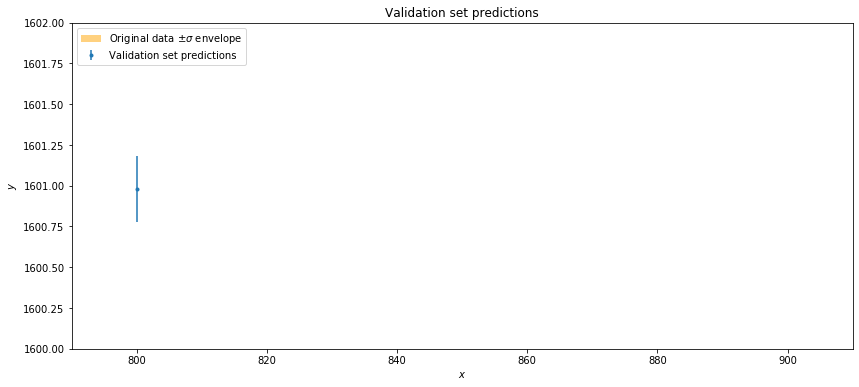

In [17]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(0,1200);
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );


# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(790,910);
plt.ylim(1600,1602);
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

The variance doesn't increase between known data, so the hypothesis failed.